In [1]:
import numpy as np
import pandas as pd
from pykrx import stock

import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
df = stock.get_market_ohlcv("20180101", "20230102", "000660")
df.head()

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2018-01-02,77300,77300,76200,76600,2014838,154679174100,0.13
2018-01-03,78100,78800,77300,77700,3097644,241244828900,1.44
2018-01-04,78700,79700,77100,77100,3729328,293227509500,-0.77
2018-01-05,78400,79400,78300,79300,3395065,268302301700,2.85
2018-01-08,79500,80000,77400,78200,2960495,231534855000,-1.39


In [3]:
# overlap 반영
train_data = df[df.index < "2021-01-01"]
valid_data = df[(df.index > "2021-01-04") & (df.index < "2022-01-01")]
test_data = df[df.index > "2022-01-03"]

In [4]:
# scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)
test_scaled = scaler.transform(test_data)

In [5]:
# target scaling : initial weight와 맞지 않을 수 있고, gradient가 빠르게 수렴, activation func 포화
scaler_y = MinMaxScaler()
train_scaled_y = scaler_y.fit_transform(train_data['종가'].values.reshape(-1,1))
valid_scaled_y = scaler_y.transform(valid_data['종가'].values.reshape(-1,1))
test_scaled_y = scaler_y.transform(test_data['종가'].values.reshape(-1,1))

In [6]:
print(train_scaled.shape, train_scaled_y.shape)

(738, 7) (738, 1)


In [7]:
# 일반적으로 Autoencoder 모델링 시 input_data의 dim보다 Dense layer의 units 수가 크다면, 
# overfitting이 발생할 수 있습니다. 따라서, 입력 차원 수(input_dim)보다 작은 수의 유닛을 가지도록 설계하는 것이 좋습니다.

# 하지만, Autoencoder 모델링의 목적은 입력 데이터의 특징(feature)을 추출하기 위한 것이므로, 
# 너무 작은 차원으로 데이터를 압축하는 것은 중요한 특징을 잃어버릴 수 있습니다.

In [8]:
# 오토인코더 모델 구성
encoder = Sequential()
encoder.add(Dense(32, activation='relu', input_shape=(train_scaled.shape[1],)))
encoder.add(Dense(16, activation='relu'))
encoder.add(Dense(8, activation='relu'))

decoder = Sequential()
decoder.add(Dense(16, activation='relu'))
decoder.add(Dense(32, activation='relu'))
decoder.add(Dense(train_scaled.shape[1], activation='linear'))

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
train_scaled_t = train_scaled[:500, :]
train_scaled_v = train_scaled[500:, :]

In [11]:
early_stopping = EarlyStopping(patience=10)
history = autoencoder.fit(train_scaled_t, train_scaled_t, epochs=25, batch_size=32, 
                          validation_data=(train_scaled_v, train_scaled_v), callbacks=[early_stopping])

Epoch 1/25
16/16 [==============================] - 0s 9ms/step - loss: 0.0899 - val_loss: 0.1384
Epoch 2/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0524
Epoch 3/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0255
Epoch 4/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0250
Epoch 5/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0222
Epoch 6/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0215
Epoch 7/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0189
Epoch 8/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0164
Epoch 9/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0149
Epoch 10/25
16/16 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0127
Epoch 11/25
16/16 [

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


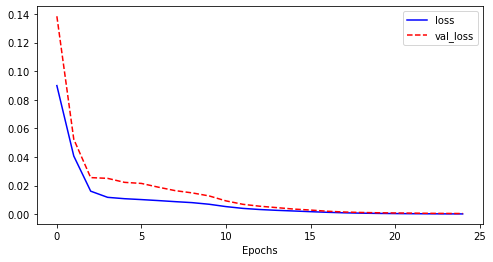

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], "b-", label="loss")
plt.plot(history.history["val_loss"], "r--", label="val_loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [13]:
denoised_train_scaled = autoencoder.predict(train_scaled)

In [14]:
print(train_scaled.shape, denoised_train_scaled.shape)

(738, 7) (738, 7)


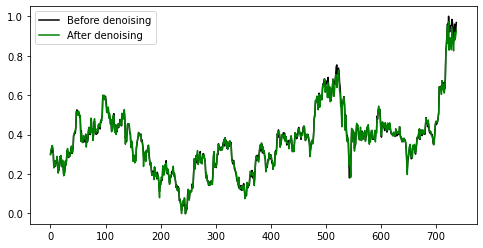

In [15]:
# denoised data 시각화 (y_true, y_denoised)
plt.figure(figsize=(8, 4))
plt.plot(train_scaled[:, 3], color='black', label="Before denoising")
plt.plot(denoised_train_scaled[:, 3], color= 'green', label="After denoising")
plt.legend()
plt.show()

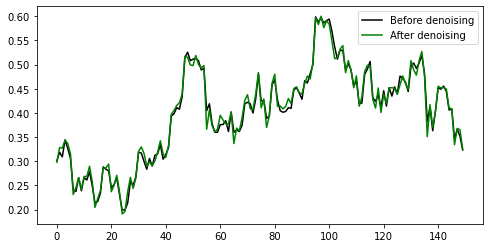

In [16]:
# denoised data 시각화 (y_true, y_denoised)
plt.figure(figsize=(8, 4))
plt.plot(train_scaled[:150, 3], color='black', label="Before denoising")
plt.plot(denoised_train_scaled[:150, 3], color= 'green', label="After denoising")
plt.legend()
plt.show()

In [17]:
prediction_days = 20

def make_datasets(prediction_days, data, scaled_y):
    X = []
    y = []
    
    for i in range(prediction_days, len(data)):
        X.append(data[i-prediction_days:i, :])
        y.append(scaled_y[i, 0])
    
    X, y = np.array(X), np.array(y)
    return X, y

In [18]:
X_train, y_train = make_datasets(20, denoised_train_scaled, train_scaled_y)
X_valid, y_valid = make_datasets(20, valid_scaled, valid_scaled_y)
X_test, y_test = make_datasets(20, test_scaled, test_scaled_y)

In [40]:
print(train_scaled.shape, valid_scaled.shape, test_scaled.shape)

(738, 7) (247, 7) (246, 7)


In [19]:
print(X_train.shape, X_valid.shape, X_test.shape)

(718, 20, 7) (227, 20, 7) (226, 20, 7)


In [39]:
print(y_train.shape, y_valid.shape, y_test.shape)

(718,) (227,) (226,)


In [20]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            11600     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data = (X_valid, y_valid))

Epoch 1/100
23/23 [==============================] - 5s 50ms/step - loss: 0.0333 - val_loss: 0.0647
Epoch 2/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0290
Epoch 3/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0119
Epoch 4/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0232
Epoch 5/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 6/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0.0124
Epoch 7/100
23/23 [==============================] - 0s 15ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 8/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0428
Epoch 9/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0268
Epoch 10/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0057

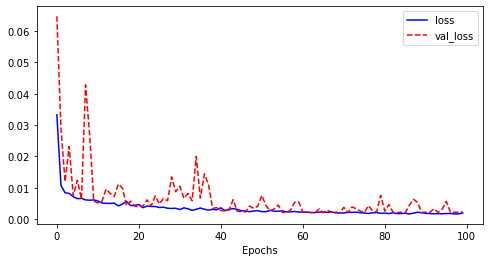

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], "b-", label="loss")
plt.plot(history.history["val_loss"], "r--", label="val_loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [23]:
# 표준화를 했기 때문에 낮게 나오는 것 같음

val_loss는 변동폭이 loss보다 크지만 전체적으로 감소하는 경향

In [24]:
model.evaluate(X_valid, y_valid)

8/8 [==============================] - 0s 4ms/step - loss: 0.0023


0.0023138232063502073

In [25]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.0014


0.0013679064577445388

In [26]:
model.predict(X_test).shape

(226, 1)

In [27]:
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

In [28]:
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))

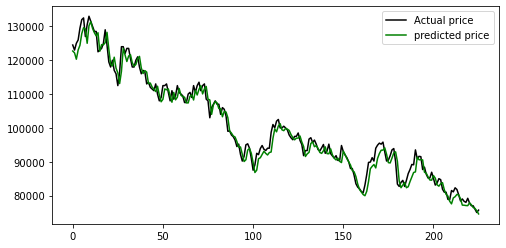

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(y_true, color='black', label="Actual price")
plt.plot(y_pred, color= 'green', label="predicted price")
plt.legend()
plt.show()

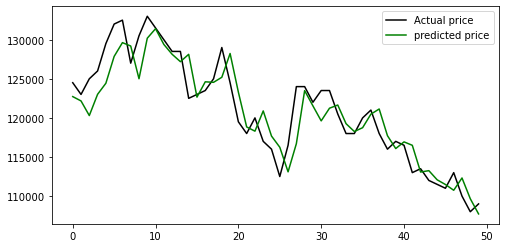

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(y_true[:50], color='black', label="Actual price")
plt.plot(y_pred[:50], color= 'green', label="predicted price")
plt.legend()
plt.show()

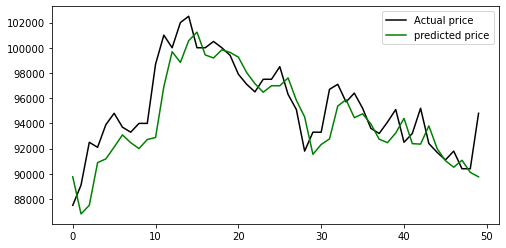

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(y_true[100:150], color='black', label="Actual price")
plt.plot(y_pred[100:150], color= 'green', label="predicted price")
plt.legend()
plt.show()

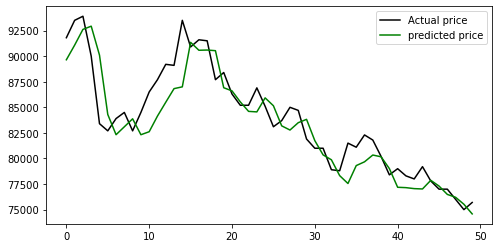

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(y_true[-50:], color='black', label="Actual price")
plt.plot(y_pred[-50:], color= 'green', label="predicted price")
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
y_pred_denoised = autoencoder.predict(test_scaled[:-20])[:, 3]
mean_squared_error(test_scaled_y[:-20], y_pred_denoised)

0.002903990006310104

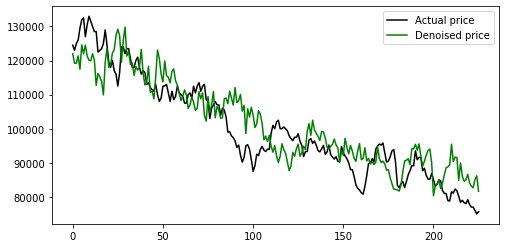

In [44]:
y_pred2 = scaler_y.inverse_transform(y_pred_denoised.reshape(-1, 1))

plt.figure(figsize=(8, 4))
plt.plot(y_true, color='black', label="Actual price")
plt.plot(y_pred2, color= 'green', label="Denoised price")
plt.legend()
plt.show()